# Problem 1. Search for an unknown signal

## 1 Preliminaries

## 1.1 Imports and Configurations

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zfit

from scipy.stats import norm, uniform, chi2
from scipy.optimize import minimize
from scipy.integrate import quad

### Constants

In [111]:
MODEL_1_TEST_FILE = '../data/raw/model1_test.csv'
MODEL_2_TEST_FILE = '../data/raw/model2_test.csv'

ALPHA = 0.05

## 1.2 Read and Clean Data

### Read

In [4]:
def read_data(model_1_test_file, model_2_test_file):
    model_1 = pd.Series(pd.read_csv(model_1_test_file, index_col=0)['M'])
    model_2 = pd.Series(pd.read_csv(model_2_test_file, index_col=0)['M'])
    return model_1, model_2

In [5]:
model_1, model_2 = read_data(MODEL_1_TEST_FILE, MODEL_2_TEST_FILE)

In [6]:
model_1.info()

<class 'pandas.core.series.Series'>
Index: 1100 entries, 0 to 1099
Series name: M
Non-Null Count  Dtype  
--------------  -----  
1100 non-null   float64
dtypes: float64(1)
memory usage: 17.2 KB


In [7]:
model_2.info()

<class 'pandas.core.series.Series'>
Index: 2000 entries, 0 to 1999
Series name: M
Non-Null Count  Dtype  
--------------  -----  
2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


## 2 EDA

## 2.1 Model 1

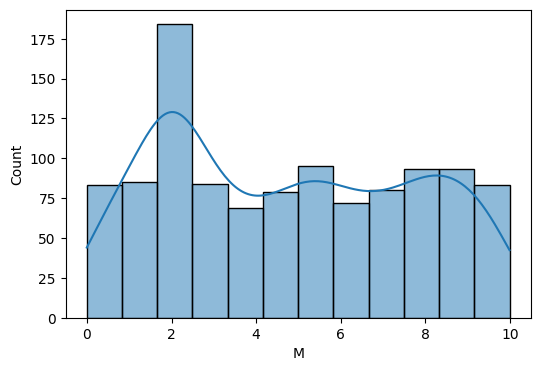

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(model_1, kde=True)

plt.show()

In [9]:
pd.DataFrame(model_1.describe()).T

,count,mean,std,min,25%,50%,75%,max
M,1100.0,4.75891,2.919974,-0.003838,2.053771,4.637162,7.445782,9.991642


### Model 2

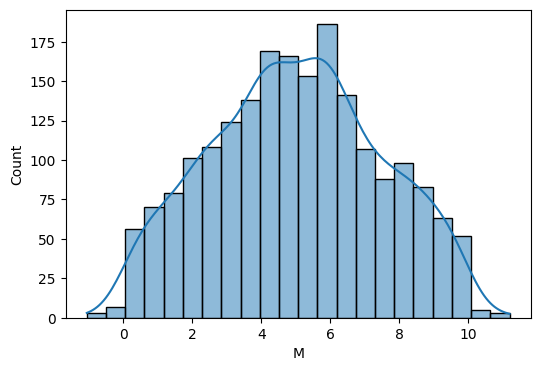

In [10]:
plt.figure(figsize=(6, 4))
sns.histplot(model_2, kde=True)

plt.show()

In [11]:
pd.DataFrame(model_2.describe()).T

,count,mean,std,min,25%,50%,75%,max
M,2000.0,5.004077,2.470644,-1.060743,3.184742,5.006277,6.738719,11.20238


## 3 Parameters Search

### Model 1

In [12]:
obs_1 = zfit.Space('x_1', limits=(0, 10))

low_1 = zfit.Parameter('low_1', 0, floating=False)
high_1 = zfit.Parameter('high_1', 10, floating=False)
uniform_1 = zfit.pdf.Uniform(obs=obs_1, low=low_1, high=high_1)

mu_1 = zfit.Parameter('mu_1', 2, 0, 5)
sigma_1 = zfit.Parameter('sigma_1', 1, 0.001, 3)
gauss_1 = zfit.pdf.Gauss(obs=obs_1, mu=mu_1, sigma=sigma_1)

f_1 = zfit.Parameter('f_1', 0.5, 0, 1)
zfit_model_1 = zfit.pdf.SumPDF([gauss_1, uniform_1], fracs=f_1)

In [14]:
data_1 = zfit.Data.from_numpy(obs=obs_1, array=model_1.values)

nll_1 = zfit.loss.UnbinnedNLL(model=zfit_model_1, data=data_1)

minimizer_1 = zfit.minimize.Minuit()
result_1 = minimizer_1.minimize(nll_1)

In [15]:
print(result_1)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_0, f_1]] data=[<zfit.core.data.Data object at 0x7f680ab6f2d0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 2.1e-05 │              2466.24 |  9819.761 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name       value  (rounded)    at limit
-------  ------------------  ----------
f_1                0.087195       False
mu_1                1.99548       False
sigma_1            0.109633       False


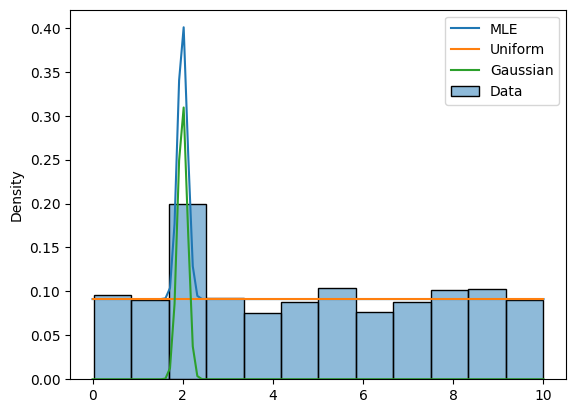

In [63]:
plot_x = np.linspace(0, 10, 100)
plot_y = zfit.run(zfit_model_1.pdf(plot_x, norm_range=obs_1))
plot_y_uniform = zfit.run(uniform_1.pdf(plot_x, norm_range=obs_1)) * (1 - f_1)
plot_y_norm = zfit.run(gauss_1.pdf(plot_x, norm_range=obs_1)) * f_1

sns.histplot(data_1.numpy(), label='Data', common_norm=False, stat='density')
sns.lineplot(x=plot_x, y=plot_y, label='MLE')
sns.lineplot(x=plot_x, y=plot_y_uniform, label='Uniform')
sns.lineplot(x=plot_x, y=plot_y_norm, label='Gaussian')
plt.show()

### Model 2

In [18]:
model_2.describe()

count    2000.000000
mean        5.004077
std         2.470644
min        -1.060743
25%         3.184742
50%         5.006277
75%         6.738719
max        11.202380
Name: M, dtype: float64

In [19]:
obs_2 = zfit.Space('x_2', limits=(0, 10))

low_2 = zfit.Parameter('low_2', 0, floating=False)
high_2 = zfit.Parameter('high_2', 10, floating=False)
uniform_2 = zfit.pdf.Uniform(obs=obs_2, low=low_2, high=high_2)

mu_2 = zfit.Parameter('mu_2', 4, 2, 8)
sigma_2 = zfit.Parameter('sigma_2', 2, 1, 4)
gauss_2 = zfit.pdf.Gauss(obs=obs_2, mu=mu_2, sigma=sigma_2)

f_2 = zfit.Parameter('f_2', 0.5, 0, 1)
zfit_model_2 = zfit.pdf.SumPDF([gauss_2, uniform_2], fracs=f_2)

In [21]:
data_2 = zfit.Data.from_numpy(obs=obs_2, array=model_2.values)

nll_2 = zfit.loss.UnbinnedNLL(model=zfit_model_2, data=data_2)

minimizer_2 = zfit.minimize.Minuit()
result_2 = minimizer_2.minimize(nll_2)

In [22]:
print(result_2)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, f_2]] data=[<zfit.core.data.Data object at 0x7f68006ffa10>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 5.3e-05 │              4443.29 |  9956.707 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name       value  (rounded)    at limit
-------  ------------------  ----------
f_2                0.540302       False
mu_2                4.98176       False
sigma_2              2.0657       False


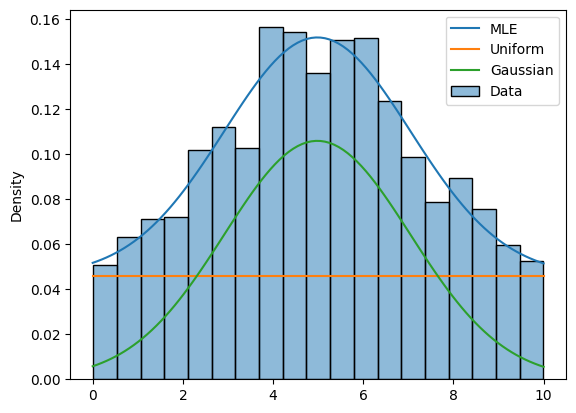

In [64]:
plot_x = np.linspace(0, 10, 100)
plot_y = zfit.run(zfit_model_2.pdf(plot_x, norm_range=obs_2))
plot_y_uniform = zfit.run(uniform_2.pdf(plot_x, norm_range=obs_2)) * (1 - f_2)
plot_y_norm = zfit.run(gauss_2.pdf(plot_x, norm_range=obs_2)) * f_2

sns.histplot(data_2.numpy(), label='Data', common_norm=False, stat='density')
sns.lineplot(x=plot_x, y=plot_y, label='MLE')
sns.lineplot(x=plot_x, y=plot_y_uniform, label='Uniform')
sns.lineplot(x=plot_x, y=plot_y_norm, label='Gaussian')
plt.show()

## 4 Bayesian Hypothesis Testing

In [108]:
def marginal_likelihood(data, a, b, mu, sigma, f):
    def likelihood(f):
        return np.prod(norm(mu, sigma).pdf(data) * f + (1 - f) / (b - a))
        
    def nll(f):
        return -np.sum(np.log(norm(mu, sigma).pdf(data) * f + (1 - f) / (b - a)))

    marg_likelihood_uniform = 1 / (b - a)
    marg_likelihood_normal = quad(likelihood, 0, 1)[0]

    B = marg_likelihood_normal / marg_likelihood_uniform
    dll = nll(0) - nll(f)
    
    return 1 - chi2(df=1).cdf(2 * dll)

### Model 1

In [116]:
p_value_1 = marginal_likelihood(data_1.numpy(), 0, 10, mu_1, sigma_1, f_1)
conclusion = 'the hypothesis is rejected' if p_value_1 < ALPHA else 'the hypothesis is not rejected'

print(f'P-value for model 1 is {p_value_1} => {conclusion}')

P-value for model 1 is 0.0 => the hypothesis is rejected


### Model 2

In [117]:
p_value_2 = marginal_likelihood(data_2.numpy(), 0, 10, mu_2, sigma_2, f_2)
conclusion = 'the hypothesis is rejected' if p_value_2 < ALPHA else 'the hypothesis is not rejected'

print(f'P-value for model 2 is {p_value_2} => {conclusion}')

P-value for model 2 is 0.0 => the hypothesis is rejected
